### Dependencies

In [6]:
# General.

import pandas as pd
import numpy as np
import warnings
from collections import Counter
import spacy
import re
import multiprocessing

# Visualizations.

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Genism. 

from gensim.models import LdaMulticore, TfidfModel, CoherenceModel, Doc2Vec
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
from gensim.models.doc2vec import TaggedDocument

# Sklearn.

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

# Ignore warnings.

warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.filterwarnings('ignore')

# Notebook setting.

sns.set_theme('notebook')

# Final project -  20597 Natural Language Processing
**Date:** May 5, 2022 <br>

**Group 8:** Jeff von Stritzky, Julia Schmidhuber & Laurens Hamm<br>
**Supervisors:** Prof. Dirk Hovy & _teaching assistant_ Amanda Cercas



Please note that this final project is split into three Jupyter Notebooks:
1. ```Preprocessing_cleaning_group_8.ipynb```
2. ```Classification_group_8.ipynb``` (this notebook)
3. ```Structured_prediction_group_8.ipynb```

The structure of this project is as follows:
1. **Research questions** <br>
<br>
2. **Data:** <br>
    2.1 Description; <br>
    2.2 Preprocessing & cleaning <u>(separate file)</u>; <br>
    2.3 Statistics; <br>
    2.4 Basic analysis. <br>
<br>
3. **Classification:** <br>
    3.1 Preparation; <br>
    3.2 Baseline models; <br>
    3.3 Predictive models; <br>
    3.4 Performance evaluation. <br>
<br>
4. **Structured Prediction:** <u>(separate file)</u> <br>
    4.1 Data preparation; <br>
    4.2 Structured perceptron; <br>
    4.3 LSTM; <br>
    4.4 Performance evaluation.

# 1. Research question

Following challenges make it increasingly harder for both companies to identify good candidates and applicants to find suitable job openings:
- Record numbers of job openings.
- Increased international mobility, hence, higher competition. Oftentimes, companies receive hundreds of applications for one vacancy.

We look at jobs in the IT industry to investigate the performance of different classification algorithms in matching a candidate with the right job title. Furthermore, we compare the performance of two structured prediction algorithms for Part-Of-Speech tagging.

The primary research questions are:
- Can augmenting resume data with job descriptions improve the F1-Score?
- What are the most accurate algorithms for classifying resumes?
- Can LSTM outperform the structured perceptron in POS tagging?


# 2. Data
## 2.1. Description
We look at two separate datasets:
* one containing resumes for IT positions;
* the second containing job descriptions for many different industries.

Our goal is to use job descriptions for data augmentation to improve the classification of the resumes. Therefore, we had to select a set of job titles that are represented both in the applications and in the descriptions. The job descriptions had to be labeled manually in order to identify descriptions with the same domain, and to eventually have the same labels for both datasets.
<br>
<br>
<br>
**Resume dataset**: Accessible via GitHub (https://github.com/florex/resume_corpus) and made available by Jiechieu, K.F.F., Tsopze, N. Skills prediction based on multi-label resume classification using CNN with model predictions explanation. Neural Comput & Applic (2020).
<br>
<br>
**Job descriptions dataset**: Accessible via Kaggle (https://www.kaggle.com/datasets/kandij/job-recommendation-datasets?select=Combined_Jobs_Final.csv)
<br>


## 2.2. Preprocessing & cleaning
<mark> This section is contained in the file ```Preprocessing_cleaning_group_8.ipynb```.</mark>

It includes the following steps:
* **Resumes**

    * Preprocessing:
        * Select job applications with unique job label
        * Select job labels that have a high-enough count and that are also present in the job descriptions
    <br>
    <br>
    * Cleaning:
        * Remove job description at the beginning
        * Remove punctuation and URLs
        * Convert number words to numeric form (for homogeneity) and then remove all digits
        * Remove stopwords
        * Remove months
        * Remove common geolocations
        * Lemmatize
        * Join collocations
    <br>
    <br>
    
* **Job descriptions**

    * Preprocessing:
        * Select only IT job descriptions
        * Within IT jobs, group similar job labels under one label (for example, *Senior systems administrator* and *Systems manager* are being grouped under *systems_administrator*)
        * Only select job labels that have a high-enough count and that are also present in the job applications
    <br>
    <br>
    * Cleaning:
        * Remove punctuation and URLs
        * Convert number words to numeric form (for homogeneity) and then remove all digits
        * Remove stopwords
        * Remove months
        * Remove geolocations
        * Lemmatize
        * Join collocations
    <br>
    <br>

## 2.3. Statistics
Before preprocessing the data, we had 29.783 resumes and 244.768 job descriptions. 

Relevant job titles where selected (see ```Preprocessing_cleaning_group_8.ipynb```), and we ended up with 11.919 resumess and 5.089 job descriptions. Each application / description represents a document.

Below, we present the number and type of tokens before and after preprocessing.

In [26]:
# Import preprocessed and cleaned datasets.

df_resumes = pd.read_csv("Resumes_cleaned.csv")
df_descriptions = pd.read_csv("Descriptions_cleaned.csv")

# Drop null values (only 14) created by empty column values. 

df_resumes = df_resumes[df_resumes.Resume_lemma.notnull()].reset_index(drop=True)
df_descriptions = df_descriptions[df_descriptions.Description_lemma.notnull()].reset_index(drop=True)

len(df_resumes), len(df_descriptions)

(11919, 5089)

### 2.3.1. Statistics on resumes

In [27]:
# Create columns with the number of tokens in the not-cleaned and the cleaned text.

df_resumes["nr_words_before"] = df_resumes.Resume.str.split().str.len()
df_resumes["nr_words_after"] = df_resumes.Resume_lemma.str.split().str.len()

# Calculate the average number of tokens in the not-cleaned and the cleaned text.

avg_nr_words_before = round(df_resumes.nr_words_before.mean())
avg_nr_words_after = round(df_resumes.nr_words_after.mean())

print(f"""Average number of words before the cleaning: {avg_nr_words_before} 
        \nAverage number of words after the cleaning: {avg_nr_words_after}
        \nSentence length was reduced by {(1-round(avg_nr_words_after/avg_nr_words_before, 2))*100}%""")

Average number of words before the cleaning: 727 
        
Average number of words after the cleaning: 475
        
Sentence length was reduced by 35.0%


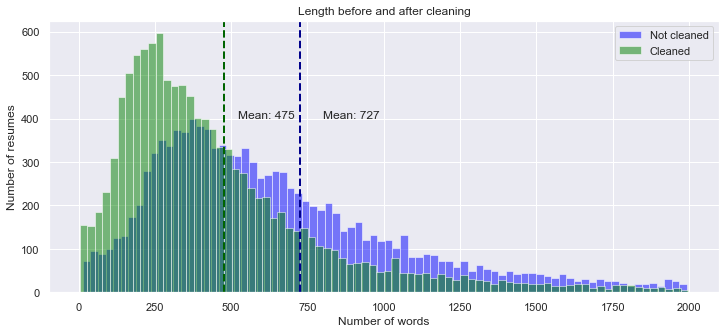

In [28]:
# Plot the distributions before and after cleaning.

fig = plt.figure(figsize = (12, 5))

plt.hist(df_resumes.nr_words_before[df_resumes.nr_words_before <2000], bins = 80, color='blue', alpha=0.5, label = 'Not cleaned')
plt.axvline(avg_nr_words_before, color='darkblue', linestyle='dashed', linewidth=2)

min_ylim, max_ylim = plt.ylim()
plt.text(avg_nr_words_before*1.1, 400, 'Mean: {:.0f}'.format(avg_nr_words_before))

plt.hist(df_resumes.nr_words_after[df_resumes.nr_words_after <2000], bins = 80, color='green', alpha=0.5, label = 'Cleaned')
plt.axvline(avg_nr_words_after, color='darkgreen', linestyle='dashed', linewidth=2)

min_ylim, max_ylim = plt.ylim()
plt.text(avg_nr_words_after*1.1, 400, 'Mean: {:.0f}'.format(avg_nr_words_after))

plt.ylabel('Number of resumes')
plt.xlabel('Number of words')
plt.title('Length before and after cleaning')

plt.legend()
plt.show()

In [29]:
# Load spacy.

nlp = spacy.load('en_core_web_sm', disable = ['ner','parser'])

# Create new empty columns for word_POS combinations of not cleaned and cleaned resumes.

df_resumes['Resumes_POS'] = None
df_resumes['Resumes_cleaned_POS'] = None

# Create a column with a (word, POS) list-of-tuples for each resume.

df_resumes.loc[:,'Resumes_POS'] = df_resumes.loc[:,'Resume'].apply(lambda x: [(token.text, token.pos_) for token in nlp(x)])


In [30]:
# Create column that contains the same (word, POS) combinations as Resumes_POS, but only for those 
# words that are in the cleaned text, meaning those words that were not eliminated in the cleaning process.

Resumes_cleaned_POS_list = []

for i in range(len(df_resumes)):
    words = set(df_resumes.loc[i, 'Resume_cleaned'].split())  # Set of words in cleaned resume.
    combinations = df_resumes.loc[i,'Resumes_POS'] # List of tuples.
    l = [w for w in combinations if w[0].lower() in words]
    Resumes_cleaned_POS_list.append(l)

df_resumes['Resumes_cleaned_POS'] = np.array(Resumes_cleaned_POS_list, dtype = object)

In [31]:
# Create lists containing only the POS tags of the tokens before and after cleaning.

Res_POS_list = []
Res_cleaned_POS_list = []

for i in df_resumes.Resumes_POS:
    pos_tags = [j[1] for j in i]
    Res_POS_list.extend(pos_tags)
    
for i in df_resumes.Resumes_cleaned_POS:
    pos_tags = [j[1] for j in i]
    Res_cleaned_POS_list.extend(pos_tags)
    
len(Res_POS_list), len(Res_cleaned_POS_list)

(10703251, 5900001)

In [32]:
# Create a dataframe containing the final count of POS tags.

Res_POS_counted = Counter(Res_POS_list).most_common()
Res_cleaned_POS_counted = Counter(Res_cleaned_POS_list).most_common()

final_counts = pd.DataFrame(Res_POS_counted, columns = ['POS', 'Count_NotCleaned']).\
                merge(pd.DataFrame(Res_cleaned_POS_counted, columns = ['POS', 'Count_Cleaned']), left_on='POS', right_on='POS') 

final_counts

,POS,Count_NotCleaned,Count_Cleaned
0,NOUN,2470553,2397707
1,PROPN,2443514,2033866
2,PUNCT,1574089,1681
3,VERB,897684,875139
4,ADP,828307,28581
5,CCONJ,545946,769
6,ADJ,510381,476250
7,DET,323752,1735
8,NUM,311798,2246
9,PART,139747,7


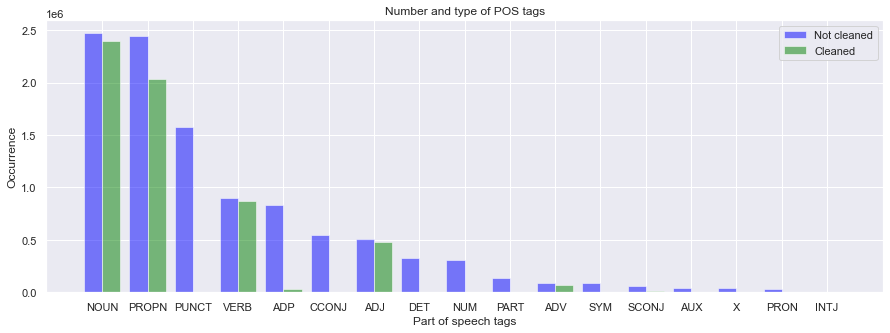

In [33]:
# Visualize the number and type of POS tags before and after cleaning.

X = final_counts.POS.tolist()
Y_NotCleaned = final_counts.Count_NotCleaned.tolist()
Y_Cleaned = final_counts.Count_Cleaned.tolist()

X_axis = np.arange(len(X))

fig = plt.figure(figsize = (15, 5))

plt.bar(X_axis - 0.2, Y_NotCleaned, 0.4, label = 'Not cleaned', color='blue', alpha=0.5)
plt.bar(X_axis + 0.2, Y_Cleaned, 0.4, label = 'Cleaned', color='green', alpha=0.5)

plt.xticks(X_axis, X)
plt.xlabel("Part of speech tags")
plt.ylabel("Occurrence")
plt.title("Number and type of POS tags")
plt.legend()
plt.show()

### 2.3.2. Statistics on job descriptions

In [12]:
# Conduct same steps as in Chapter 2.3.1.

df_descriptions["nr_words_before"] = df_descriptions.FullDescription.str.split().str.len()
df_descriptions["nr_words_after"] = df_descriptions.Description_lemma.str.split().str.len()

avg_nr_words_before = round(df_descriptions.nr_words_before.mean())
avg_nr_words_after = round(df_descriptions.nr_words_after.mean())

print(f"""Average number of words before the cleaning: {avg_nr_words_before} 
        \nAverage number of words after the cleaning: {avg_nr_words_after}
        \nSentence length was reduced by {(1-round(avg_nr_words_after/avg_nr_words_before, 2))*100}%""")

Average number of words before the cleaning: 264 
        
Average number of words after the cleaning: 157
        
Sentence length was reduced by 41.0%


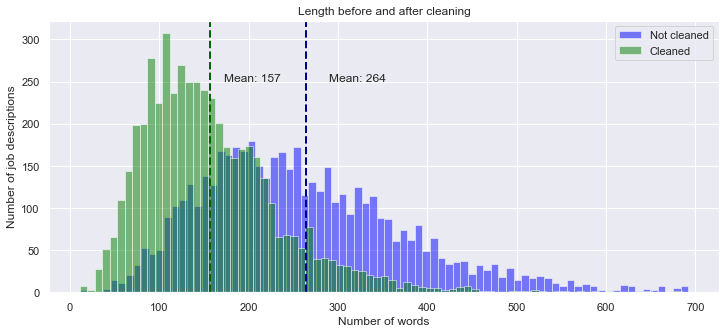

In [13]:
# Plot the distributions before and after cleaning.

fig = plt.figure(figsize = (12, 5))

plt.hist(df_descriptions.nr_words_before[df_descriptions.nr_words_before <700], bins = 80, color='blue', alpha=0.5, label = 'Not cleaned')
plt.axvline(avg_nr_words_before, color='darkblue', linestyle='dashed', linewidth=2)

min_ylim, max_ylim = plt.ylim()
plt.text(avg_nr_words_before*1.1, 250, 'Mean: {:.0f}'.format(avg_nr_words_before))

plt.hist(df_descriptions.nr_words_after[df_descriptions.nr_words_after <700], bins = 80, color='green', alpha=0.5, label = 'Cleaned')
plt.axvline(avg_nr_words_after, color='darkgreen', linestyle='dashed', linewidth=2)

min_ylim, max_ylim = plt.ylim()
plt.text(avg_nr_words_after*1.1, 250, 'Mean: {:.0f}'.format(avg_nr_words_after))

plt.ylabel('Number of job descriptions')
plt.xlabel('Number of words')
plt.title('Length before and after cleaning')

plt.legend()
plt.show()

In [14]:
# Load spacy.

nlp = spacy.load('en_core_web_sm', disable = ['ner','parser'])

# Create new empty columns for word_POS combinations of not cleaned and cleaned job descriptions.

df_descriptions['FullDescr_POS'] = None
df_descriptions['Descr_cleaned_POS'] = None

# Create a column with (word, POS) lists for each resume.

df_descriptions.loc[:,'FullDescr_POS'] = df_descriptions.loc[:,'FullDescription'].apply(lambda x: [(token.text, token.pos_) for token in nlp(x)])


In [15]:
# Create column that contains the same (word, POS) combinations as FullDescr_POS, but only for those 
# words that are in the cleaned text, meaning those words that were not eliminated in the cleaning process.

Descr_cleaned_POS = []

for i in range(len(df_descriptions)):
    words = set(df_descriptions.loc[i, 'Description_cleaned'].split())  # Set of words in cleaned resume.
    combinations = df_descriptions.loc[i,'FullDescr_POS'] # List of tuples.
    l = [w for w in combinations if w[0].lower() in words]
    Descr_cleaned_POS.append(l)

df_descriptions['Descr_cleaned_POS'] = np.array(Descr_cleaned_POS, dtype=object)

In [16]:
# Create lists containing only the POS tags of the tokens before and after cleaning.

Descr_POS_list = []
Descr_cleaned_POS_list = []

for i in df_descriptions.FullDescr_POS:
    pos_tags = [j[1] for j in i]
    Descr_POS_list.extend(pos_tags)
    
for i in df_descriptions.Descr_cleaned_POS:
    pos_tags = [j[1] for j in i]
    Descr_cleaned_POS_list.extend(pos_tags)
    
len(Descr_POS_list), len(Descr_cleaned_POS_list)

(1587289, 817271)

In [17]:
# Create a dataframe containing the final count of POS tags.

Descr_POS_counted = Counter(Descr_POS_list).most_common()
Descr_cleaned_POS_counted = Counter(Descr_cleaned_POS_list).most_common()

final_counts = pd.DataFrame(Descr_POS_counted, columns = ['POS', 'Count_NotCleaned']).\
                merge(pd.DataFrame(Descr_cleaned_POS_counted, columns = ['POS', 'Count_Cleaned']), left_on='POS', right_on='POS') 

final_counts

,POS,Count_NotCleaned,Count_Cleaned
0,NOUN,363117,349207
1,PROPN,213201,185898
2,PUNCT,210296,28
3,ADP,146544,9334
4,VERB,137034,135557
5,ADJ,109986,102591
6,DET,104345,384
7,CCONJ,72226,839
8,AUX,68545,4544
9,PRON,40637,809


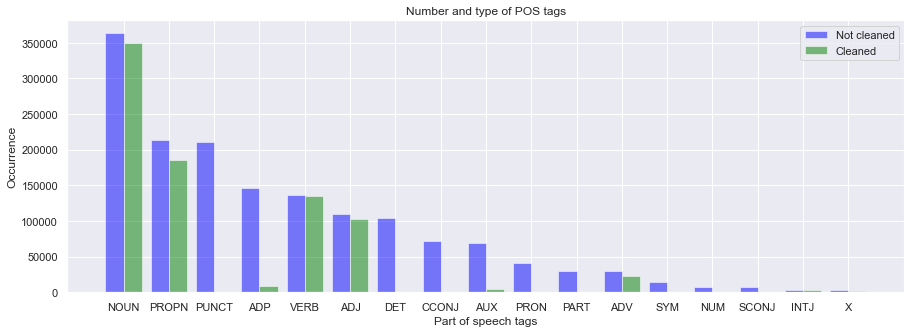

In [18]:
# Visualize the number and type of POS tags before and after cleaning.

X = final_counts.POS.tolist()
Y_NotCleaned = final_counts.Count_NotCleaned.tolist()
Y_Cleaned = final_counts.Count_Cleaned.tolist()

X_axis = np.arange(len(X))

fig = plt.figure(figsize = (15, 5))

plt.bar(X_axis - 0.2, Y_NotCleaned, 0.4, label = 'Not cleaned', color='blue', alpha=0.5)
plt.bar(X_axis + 0.2, Y_Cleaned, 0.4, label = 'Cleaned', color='green', alpha=0.5)

plt.xticks(X_axis, X)
plt.xlabel("Part of speech tags")
plt.ylabel("Occurrence")
plt.title("Number and type of POS tags")
plt.legend()
plt.show()

## 2.4. Basic analysis
To acquire some preliminary insights into the data, we perform the following two basic analyses on the **training** data: <br> 
1) Topic modeling with LDA; <br>
2) Clustering of document embeddings; <br>
3) Dimensionality reduction on tf-idf vectors.

### Split data into training, development & testing set

In [2]:
# Load resumes data again for a fresh start.

df_resumes = pd.read_csv("Resumes_cleaned.csv")
df_resumes = df_resumes[df_resumes.Resume_cleaned.notnull()].reset_index(drop=True)

In [3]:
# Define train, development and test proportions.

N = df_resumes.shape[0]

train_prop = 0.5
dev_prop = 0.25
test_prop = 0.25

# Split the resumes dataset into training (+ dev) and testing part.

X_resumes = df_resumes["Resume_lemma"]
y_resumes = df_resumes["Label"]

X_train_dev, X_test, y_train_dev, y_test = train_test_split(X_resumes, y_resumes, 
                                                            shuffle = True, 
                                                            stratify = y_resumes,
                                                            train_size = (train_prop + dev_prop), 
                                                            random_state = 999)

# Split the resume training set into training and development sets.

X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, 
                                                  shuffle = True, 
                                                  stratify = y_train_dev,
                                                  test_size = dev_prop / (train_prop + dev_prop), 
                                                  random_state = 999)

# Check sizes of resulting dataframes after splitting.

print(f'''Training data: {round((X_train.shape[0]/N)*100,1)}%
Development data: {round((X_dev.shape[0]/N)*100,1)}%
Test data: {round((X_test.shape[0]/N)*100,1)}%''')

Training data: 50.0%
Development data: 25.0%
Test data: 25.0%


### 2.4.1. Topic models

First, we deployed topic models to analyze if a unsupervised algorithm could already uncover clusters with sets of terms that are indicative for the different job labels in our dataset. 

In [19]:
# Create a list of lists of the lemmatized text.

instances = [d.split() for d in pd.DataFrame(X_train).Resume_lemma.reset_index(drop = True).tolist()]

# Create dictionary.

phrases = Phrases(instances, min_count = 2, threshold = 1, delimiter = '_', connector_words = ENGLISH_CONNECTOR_WORDS)
instances_colloc = phrases[instances]

dictionary = Dictionary(instances_colloc)
print("Dictionary length before filter: ", len(dictionary))

dictionary.filter_extremes(no_below = 10, no_above = 0.70) 
print("Dictionary length after filter: ", len(dictionary))

Dictionary length before filter:  123190
Dictionary length after filter:  21444


In [20]:
# Turn corpus into TFIDF weighted matrix.

ldacorpus = [dictionary.doc2bow(text) for text in instances]

# Learn TFIDF values from corpus.

tfidfmodel = TfidfModel(ldacorpus)

# Transform raw frequencies into TFIDF.

model_corpus = tfidfmodel[ldacorpus]

In [9]:
# Find appropriate number of topics for the resumes.

coherence_values = []

for num_topics in range(3, 10):
    model = LdaMulticore(corpus = model_corpus,
                         id2word = dictionary, 
                         num_topics = num_topics,
                         random_state = 3)

    coherencemodel_umass = CoherenceModel(model = model, 
                         texts = instances, 
                         dictionary = dictionary, 
                         coherence = 'u_mass')

    coherencemodel_cv = CoherenceModel(model = model, 
                         texts = instances, 
                         dictionary = dictionary, 
                         coherence = 'c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print("Number of topics:", num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

Number of topics: 3 -0.8104406666629766 0.2894386565758036
Number of topics: 4 -0.8619564693937558 0.30648138415982024
Number of topics: 5 -0.8806741464675845 0.2933825343302491
Number of topics: 6 -0.8652513769219009 0.3077650756969103
Number of topics: 7 -0.8532836989131007 0.3238146099959733
Number of topics: 8 -0.8426014509761791 0.30466540449507706
Number of topics: 9 -0.8170482304734429 0.30442566857032305


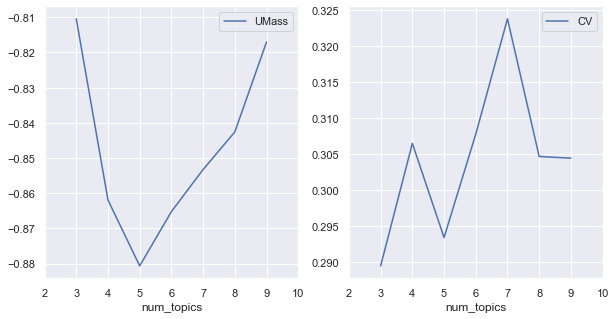

In [10]:
scores = pd.DataFrame(coherence_values, columns = ['num_topics', 'UMass', 'CV'])

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
scores.plot.line(x = 'num_topics', y = 'UMass', ax = ax[0], xticks = range(2,11))
scores.plot.line(x = 'num_topics', y = 'CV', ax = ax[1], xticks = range(2,11))
plt.show()

<mark>According to these plots, either **4 or 7** topics seem most suitable. By trial-and-error, we find that **4** topics makes most sense content-wise. </mark>

In [21]:
num_topics = 4

# Find chunksize to make about 200 updates.

num_passes = 5
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

# Fit LDA model.
# The result is a distribution over the topics for each document.

model = LdaMulticore(num_topics = num_topics, 
                     corpus = model_corpus, 
                     id2word = dictionary, 
                     workers = min(10, multiprocessing.cpu_count()-1),
                     passes = num_passes, 
                     chunksize = chunk_size,
                     alpha = 0.5,
                     random_state = 3)

# Transform the data into topic distros.

topic_corpus = model[model_corpus]

148.975


In [22]:
# Get rid of cumbersome formatting.

topic_sep = re.compile("0\.[0-9]{3}\*")

# Extract a list of tuples with topic number and descriptors from the model.

model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) 
                for topic_no, model_topic in
                model.print_topics(num_topics = num_topics, num_words = 5)]

descriptors = []

for i, m in model_topics:
    print(i + 1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:5]).replace('"', ''))


1 "project", "project_manager", "business", "sale", "budget"
2 "database", "oracle", "sql_server", "sql", "rman"
3 "security", "network", "server", "year", "cisco"
4 "year", "network", "system_administrator", "security", "database"


In [24]:
# Get a list with the topic scores for each resume.

scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(instances))]

# Turn scores into a dataframe.

topic_distros = pd.DataFrame(data = scores, columns = descriptors)

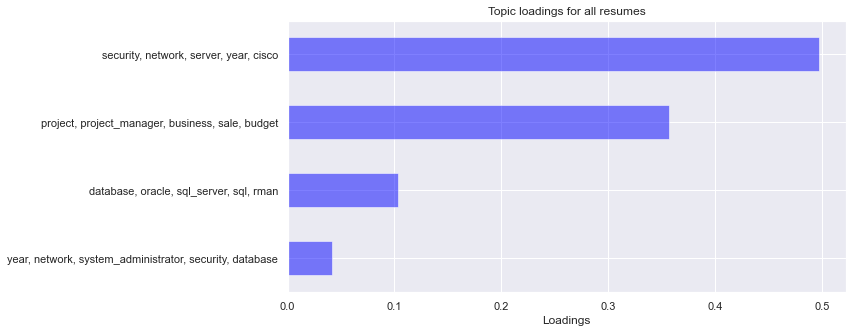

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))

# Aggregate across all resumes and plot the graph.

aggregate = topic_distros.mean().sort_values()

aggregate.plot.barh(ax = ax, color = 'blue', alpha = 0.5)
plt.title("Topic loadings for all resumes")
plt.xlabel("Loadings")
plt.show()

## 2.4.2. Document embeddings

Secondly, we analyze if document embeddings of resumes might already show some clusters that could resemble different job labels.

In [55]:
# Create the document corpus as well as corresponding Doc2Vec representation.

corpus = []
i = 0

for row in pd.DataFrame(X_train).iterrows():
    label = i
    i += 1
    text = row[1].Resume_lemma
    corpus.append(TaggedDocument(words=text.split(), 
                                 tags=[str(label)]))

print('done')

d2v_model = Doc2Vec(vector_size = 150, 
                    window = 30,
                    hs = 0,
                    sample = 0.0001,
                    negative = 5,
                    min_count = 10,
                    workers = -1,
                    epochs = 500,
                    dm = 0, 
                    dbow_words = 1)

d2v_model.build_vocab(corpus)
d2v_model.train(corpus, total_examples = d2v_model.corpus_count, epochs = d2v_model.epochs)


done


#### First, we show the document embeddings labeled with the original labels. We reduce the number of dimensions using PCA to be able to plot it using 2 axes.

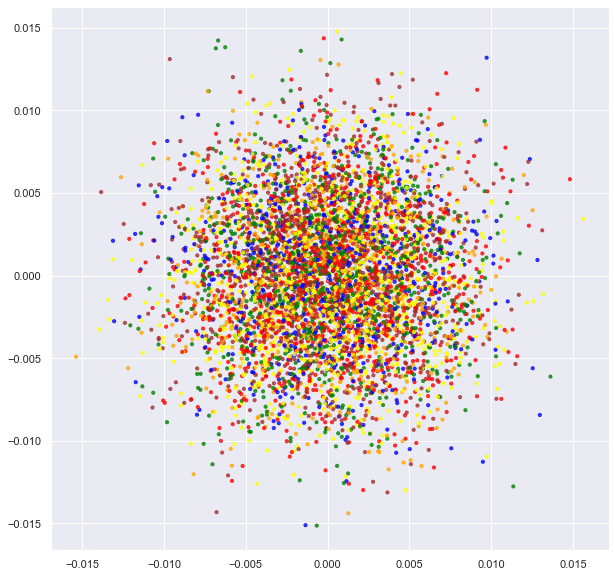

In [56]:
# Apply PCA on document embeddings & plotting with the actual labels.

y_train_num = []

for y in y_train:
    if y == "Software_Developer": y_train_num.append(0)
    if y == "Database_Administrator": y_train_num.append(1)
    if y == "Network_Administrator": y_train_num.append(2)
    if y == "Systems_Administrator": y_train_num.append(3)
    if y == "Project_manager": y_train_num.append(4)
    if y == "Security_Analyst": y_train_num.append(5)

pca = PCA(n_components = 2).fit(d2v_model.dv.vectors)
data = pca.transform(d2v_model.dv.vectors)

label_ = ['green', 'red', 'blue', 'yellow' , 'brown', 'orange']
color = [label_[i] for i in y_train_num]

plt.rcParams["figure.figsize"] = [10, 10] 
plt.scatter(data[:, 0], data[:, 1], c = color, alpha = 0.75, s = 10)
plt.show()

#### Now, we perform K-means clustering using 6 clusters on the document embeddings, followed by PCA to reduce the number of dimensions, and plot them labeled with the predicted labels. The black triangles indicate the centroids of the clusters.

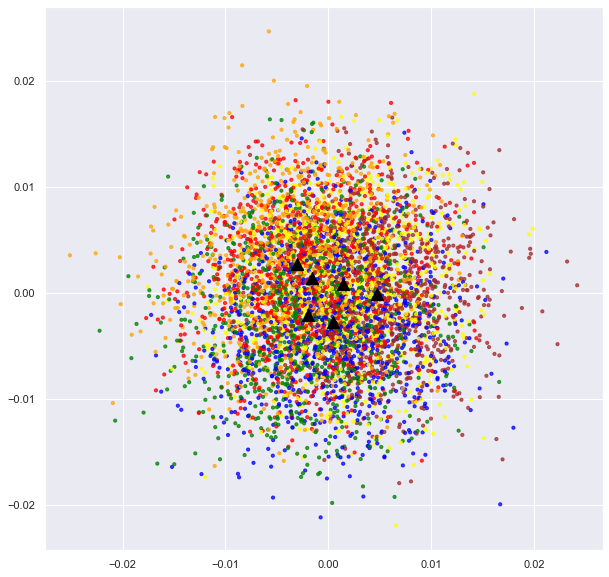

In [48]:
# Clustering of document vectors.

kmeans_model = KMeans(n_clusters = 6, max_iter = 500) # 6 clusters to ideally match the 6 labels.
X = kmeans_model.fit(d2v_model.dv.vectors)
labels = kmeans_model.labels_.tolist()

# Reduce number of dimensions to 2 for plotting.

pca = PCA(n_components = 2).fit(d2v_model.dv.vectors)
data = pca.transform(d2v_model.dv.vectors)

label_ = ['green', 'red', 'blue', 'yellow' , 'brown', 'orange']
color = [label_[i] for i in labels] # Predicted labels by k-means.

# Plot 2-D plot.

plt.rcParams["figure.figsize"] = [10, 10] 
plt.scatter(data[:, 0], data[:, 1], c = color, alpha = 0.75, s = 10)

centroids = pca.transform(kmeans_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], marker= '^', s = 150, c = 'black')
            
plt.show()

#### Lastly, we plot the clustered and reduced document embeddings in 3D.

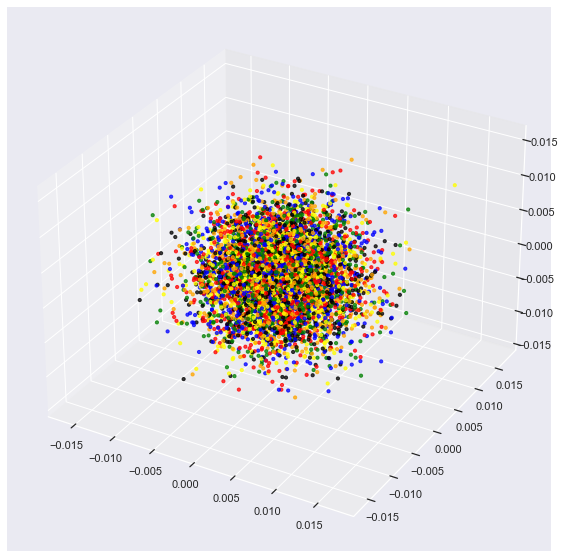

In [57]:
# Plot 3-D plot.

l = kmeans_model.fit_predict(d2v_model.dv.vectors)
pca = PCA(n_components = 3).fit(d2v_model.dv.vectors) # 3 dimensions.
data = pca.transform(d2v_model.dv.vectors)

label_ = ['green', 'red', 'blue', 'yellow', 'black', 'orange']
color = [label_[i] for i in labels]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(data[:, 0], data[:, 1], data[:, 2], c = color, alpha = 0.75, s = 10)

plt.show()

Unfortunately, document embeddings show little separability or clusters. To preserve local similarity, we also tried TSNE for dimensionality reduction with different perplexity settings but, still, no clear clusters were detected. 

## 2.4.3. Dimensionality reduction

Finally, we also conduct and visualize dimensionality reduction using SVD and NMF to see if the six different job labels can be at least somehow separated in a two dimensional space.

In [4]:
# Put training data into tf-idf matrix for dimensionality reduction. 

tfidf_vectorizer_for_vis = TfidfVectorizer(ngram_range = (1,3), 
                                   stop_words = 'english', 
                                   analyzer = 'word', 
                                   sublinear_tf = True,
                                   max_features = round(len(X_train)*0.8)) # To ensure less features then instances
    
tfidf_train_for_vis = tfidf_vectorizer_for_vis.fit_transform(X_train.values.astype('U'))  

In [7]:
# Reduce the TDIDF Matrix to two dimensions for two-dimensional visualization. 

two_dim_svd = TruncatedSVD(n_components=2)
two_dim_svd = two_dim_svd.fit_transform(tfidf_train_for_vis)

two_dim_nmf = NMF(n_components=2, init='nndsvd', random_state=0)
two_dim_nmf = two_dim_nmf.fit_transform(tfidf_train_for_vis)

In [8]:
# Put result into dataframe for plotting. 

svd_twodim_df = pd.DataFrame({'First Dimension': two_dim_svd[:,0], 'Second Dimension': two_dim_svd[:,1],
                              "Label" : y_train})
nmf_twodim_df = pd.DataFrame({'First Dimension': two_dim_nmf[:,0], 'Second Dimension': two_dim_nmf[:,1],
                              "Label" : y_train})

<AxesSubplot:title={'center':'First two Dimensions for NMF'}, xlabel='First Dimension', ylabel='Second Dimension'>

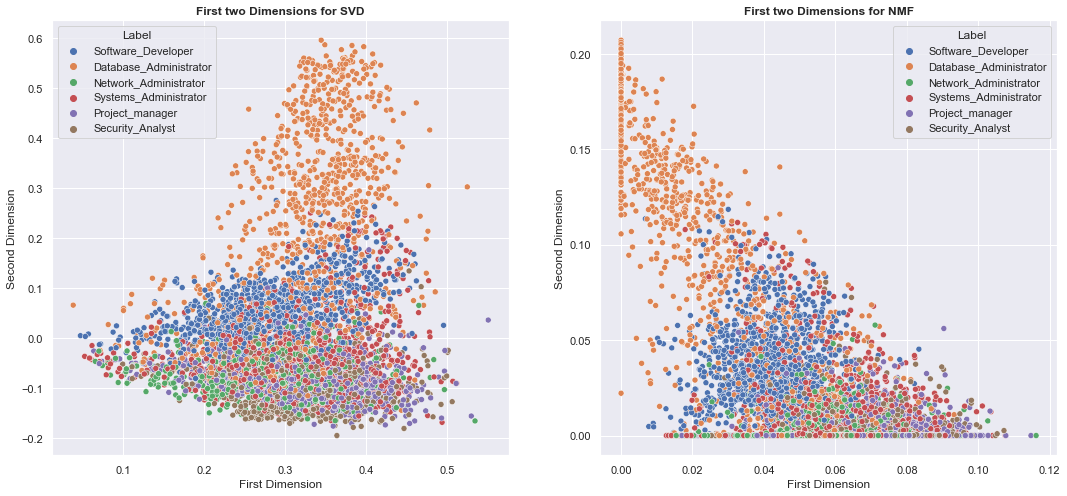

In [9]:
# Plot scatter for 2D SVD and NMF. 

fig, ((ax1, ax2)) = plt.subplots(nrows = 1,ncols=2, figsize=(18, 8))
ax1.set_title('First two Dimensions for SVD', weight = "bold")
sns.scatterplot(data = svd_twodim_df, x = "First Dimension", y = "Second Dimension", 
                hue = "Label", ax = ax1)

ax2.set_title('First two Dimensions for NMF', weight = "bold")
sns.scatterplot(data = nmf_twodim_df, x = "First Dimension", y = "Second Dimension", 
                hue = "Label", ax = ax2)

Dimensionality reduction already suggests good separability for at least the Database Administrator and Software Developer. This lays a solid foundation for the following classification. 

# 3. Classification

This comprehensive section contains the following elements:

1. Preparation: <br>
    1.1 Load preprocessed and cleaned **resume** and **descriptions** datasets; <br>
    1.2 Training, development & testing split **resumes**; <br>
    1.3 Data augmentation and the selection of the final training data. <br>
<br>
2. Baseline classification models: <br>
    2.1 Most-frequent-label prediction;<br>
    2.2 Logistic regression with default parameters. <br>
<br>
3. Selected classification models (<u>trained on selected augmented data, tuned on development data</u>): <br>
    3.1 Tf-idf vectorizer optimization; <br>
    3.2 Logistic regression with fine-tuned parameters; <br>
    3.3 Naive bayes classifier; <br>
    3.4 Random forest classifier; <br>
    3.5 Visualization of model improvements. <br>
<br>
4. Final performance evaluation and comparison: <br>
    4.1 Test data predictions and bootstrap sampling significance tests; <br>
    4.2 Overall model comparisons; <br>
    4.3 Insights into most predictive features.

## 3.1. Preparation
### 3.1.1. Load data

In [6]:
# Load resumes.

df_resumes = pd.read_csv("Resumes_cleaned.csv")
df_resumes = df_resumes.rename(columns = {"Resume_lemma" : "Description"})

# Inspect head.

df_resumes.head(2)

,Resume,Label,Resume_cleaned,Description
0,"Database Administrator <span class=""hl"">Databa...",Database_Administrator,family private care llc lawrenceville self mot...,family private care llc lawrenceville self mot...
1,"Database Administrator <span class=""hl"">Databa...",Database_Administrator,sql server database administrator database adm...,sql_server database_administrator database_adm...


In [7]:
# Load descriptions.

df_descriptions = pd.read_csv("Descriptions_cleaned.csv")
df_descriptions = df_descriptions.rename(columns = {"Description_lemma" : "Description"})

# Inspect head.

df_descriptions.head(2)

,FullDescription,Label,Description_cleaned,Description
0,Job Title: Senior Support/Network Analyst Loca...,Network_Administrator,job title senior support network analyst locat...,job title senior support network analyst locat...
1,Our client is a Global organisation providing ...,Network_Administrator,client global organisation providing support p...,client global organisation provide support pro...


### 3.1.2. Training, development & testing split

In [8]:
# Set train, development and test proportions.

N = df_resumes.shape[0]

train_prop = 0.5
dev_prop = 0.25
test_prop = 0.25

# Split the resumes dataset into training (+ dev) and testing part.

X_resumes = df_resumes["Description"]
y_resumes = df_resumes["Label"]

X_train_dev, X_test, y_train_dev, y_test = train_test_split(X_resumes, y_resumes, 
                                                            shuffle = True, 
                                                            stratify = y_resumes, 
                                                            train_size = (train_prop + dev_prop), 
                                                            random_state = 999)

# Split the resume training set into training and development sets.

X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, 
                                                  shuffle = True, 
                                                  test_size = dev_prop / (train_prop + dev_prop), 
                                                  random_state = 999,
                                                  stratify = y_train_dev)

# Check sizes of resulting dataframes after splitting.

print(f'''Training data: {round((X_train.shape[0]/N)*100,1)}%
Development data: {round((X_dev.shape[0]/N)*100,1)}%
Test data: {round((X_test.shape[0]/N)*100,1)}%''')

Training data: 50.0%
Development data: 25.0%
Test data: 25.0%


### 3.1.3. Data augmentation

Data augmentation is a technique that allows for higher model prediction accuracy by reducing overfit and increasing its generalization ability. 

In this case, we did not generate new data points from existing data, but we decided to add job descriptions to our training data. Job descriptions are usually written in more general terms than resumes, and can be interpreted as “the perfect resume” for a certain position. By doing this, we are hoping to improve the generalizability and performance of our model.

By keeping the proportion of data points for each category constant, we checked the performance of the augmented model for different levels of augmentation. We found that by increasing the training data, the prediction performance increases significantly (approximately 1 percent point).

#### 3.1.3.1. Defining functions for mixing the datasets and evaluating performance

In [9]:
# Define function to mix different proportions of resumes to the initial training set of resumes.

def mix_training(X_train, y_train, df_descriptions, percentage_extra):
    X_train_mixed = X_train.copy()
    y_train_mixed = y_train.copy()
        
    # Return pure resume training data if no percentage is added. 
    
    if percentage_extra == 0: 
        
        return X_train, y_train
    
    # Combine both datasets if extra percentage = 100%. 
    
    elif percentage_extra == 1: 
        X_train_mixed = X_train_mixed.append(df_descriptions["Description"])
        y_train_mixed = y_train_mixed.append(df_descriptions["Label"])
        
        return X_train_mixed, y_train_mixed
    
    # Use same distribution as in resume training set for mixing if extra percentage <45%. 
    
    elif percentage_extra <= 0.45: 
        train_counts = list(y_train.value_counts())
        train_labels = list(y_train.value_counts().index)

        for i in range(len(train_counts)):
            sample = df_descriptions[df_descriptions['Label'] == train_labels[i]].\
                sample(n = round(train_counts[i] * percentage_extra), random_state = 999)

            X_train_mixed = X_train_mixed.append(sample['Description'])
            y_train_mixed = y_train_mixed.append(sample['Label'])

        return X_train_mixed, y_train_mixed

    # Add stratified split of descriptions if extra percentage > 45%.
    
    else: 
        X_train_des, X_rest, y_train_des, y_rest = train_test_split(df_descriptions["Description"], 
                                                                    df_descriptions["Label"], 
                                                                    shuffle = True, 
                                                                    stratify = df_descriptions["Label"], 
                                                                    train_size = percentage_extra, 
                                                                    random_state = 999)

        X_train_mixed = X_train_mixed.append(X_train_des)
        y_train_mixed = y_train_mixed.append(y_train_des)

        return X_train_mixed, y_train_mixed 

<br>

<mark> **Note:** The following function already makes use of three functions defined only later in this Notebook: <br></mark>
1. **get_tfidf (3.1.3.3)**; <br>
2. **logistic_regression_baseline (3.2.2)**; <br>
3. **bootstrap_sample (3.4.1.)**. <br>
<br>

This was done to improve overall readability, flow and structure of the notebook. 

In [11]:
# Define a function to evaluate improvements in F1-Score for different proportions of Data Augmentation.

def evaluate_augmentation_performance(): 
    performance = {"Mixing Percentage" : [], "Micro F1-Score" : [], "Significant" : []}
    
    for perc in np.linspace(0, 1, 21): # Proportions 0 - 100% in steps of 5%.
        
        # Conduct logistic regression with pure dataset if percentage is zero.
        
        if perc == 0: 
            
            X_train_pure, X_dev_pure, X_test_pure = get_tfidf(X_train, X_dev, X_test)
            logistic_regression_pure = logistic_regression_default(X_train_pure, y_train, X_dev_pure, y_dev)
            
            performance["Significant"].append(0)
            performance["Mixing Percentage"].append(perc)
            performance["Micro F1-Score"].append(logistic_regression_pure[0]['accuracy'])
        
        # Conduct tfidf and logistic regression and bootstrap sample test for mixed set if percentage != 0. 
       
        else: 

            # Construct augmented/mixed training datasets by adding proportions of job descriptions and vectorize.
            
            X_train_mixed, y_train_mixed = mix_training(X_train, y_train, df_descriptions, perc)
            X_train_mixed, X_dev_mixed, X_test_mixed = get_tfidf(X_train_mixed, X_dev, X_test)

            # Fit default logistic regression.
            
            logistic_regression_mixed = logistic_regression_default(X_train_mixed, y_train_mixed, X_dev_mixed, y_dev)

            # Perform bootstrap sampling test.
            
            if logistic_regression_mixed[0]['accuracy'] <= logistic_regression_pure[0]['accuracy']: 
                performance["Significant"].append(0)

            else: 
                p_value, deltas = bootstrap_sample(logistic_regression_mixed[1], logistic_regression_pure[1], y_dev)
                
                if p_value < 0.01:
                    performance["Significant"].append(1)
                    
                else:  
                    performance["Significant"].append(0)

            # Append baseline logistic regression prediction for augmented training datasets.
            
            performance["Mixing Percentage"].append(perc)
            performance["Micro F1-Score"].append(logistic_regression_mixed[0]['accuracy'])
        
    return performance 

#### 3.1.3.2. Evaluating performance differences and deciding on final split

In [12]:
# Run performance evaluation function. Takes ~1h.

performance_dict = evaluate_augmentation_performance()

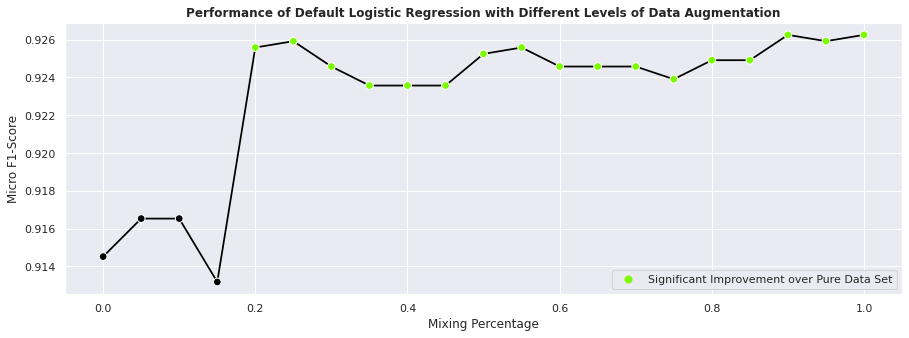

In [13]:
# Plot performance evaluation. 

performance_df = pd.DataFrame(performance_dict)

colors = {0:'black', 1:'lawngreen'}

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(performance_df['Mixing Percentage'], performance_df['Micro F1-Score'], color='black', lw = 1.75)
ax.scatter(performance_df['Mixing Percentage'], performance_df['Micro F1-Score'], 
           c=performance_df['Significant'].map(colors), zorder=3, edgecolors = "white", marker = "o", s = 60)

ax.set_title("Performance of Default Logistic Regression with Different Levels of Data Augmentation", weight='bold')
ax.set_ylabel("Micro F1-Score")
ax.set_xlabel("Mixing Percentage")

blue_star = mlines.Line2D([], [], color='lawngreen', marker='o', linestyle='None',
                          markersize=7, label='Significant Improvement over Pure Data Set')
plt.legend(handles=[blue_star])
plt.show()

The performance evaluation shows that data augmentation results in a significant improvement of F1-Score over the pure dataset. As the F1-Score converges towards 0.92, starting between 40% and 50% of added descriptions data, we **decided to proportionally add 25% of the description set to the resumes training set.**

#### 3.1.3.3. Finalizing and transforming training set with selected augmentation proportion

In [11]:
# Retrieve default TF-IDF matrix.

def get_tfidf(train, dev, test):
    tfidf_vectorizer = TfidfVectorizer(ngram_range = (2,6), 
                                   stop_words = 'english', 
                                   analyzer = 'char', 
                                   sublinear_tf = True,
                                   max_features = round(len(train)*0.8)) # To ensure less features then instances
    
    tfidf_train = tfidf_vectorizer.fit_transform(train.values.astype('U'))  
    tfidf_dev = tfidf_vectorizer.transform(dev.values.astype('U'))
    tfidf_test = tfidf_vectorizer.transform(test.values.astype('U'))  

    return tfidf_train, tfidf_dev, tfidf_test

In [12]:
# Define the final train set based on selected proportions. 

percentage_extra = 0.25

# Get new X_train and y_train. 

X_train, y_train = mix_training(X_train, y_train, df_descriptions, percentage_extra)

# Vectorize augmented training data.

X_train_tfidf, X_dev_tfidf, X_test_tfidf = get_tfidf(X_train, X_dev, X_test)

## 3.2. Baseline models
### 3.2.1. Most-frequent-label prediction

In [13]:
# Construct the frequent class classifier.

most_frequent = DummyClassifier(strategy = 'most_frequent')

# Predict development set using only the most frequent class.

most_frequent.fit(X_train_tfidf, y_train)
most_frequent_prediction_dev = most_frequent.predict(X_dev_tfidf)

results_most_frequent = classification_report(y_dev, most_frequent_prediction_dev, output_dict = True)

print("\nClassification Report for Most-Frequent Label Prediction \n \n" +
      classification_report(y_dev, most_frequent_prediction_dev))


Classification Report for Most-Frequent Label Prediction 
 
                        precision    recall  f1-score   support

Database_Administrator       0.00      0.00      0.00       556
 Network_Administrator       0.00      0.00      0.00       366
       Project_manager       0.00      0.00      0.00       585
      Security_Analyst       0.00      0.00      0.00       391
    Software_Developer       0.00      0.00      0.00       498
 Systems_Administrator       0.20      1.00      0.33       587

              accuracy                           0.20      2983
             macro avg       0.03      0.17      0.05      2983
          weighted avg       0.04      0.20      0.06      2983



As the dataset has 6 labels, and the most represented label occurs only in 20% of the entries, this baseline model shows an awful performance.

### 3.2.2. Logistic regression with default parameters

In [14]:
# Construct the logistic regression classifier as a method for repeated usage.

def logistic_regression_default(X_train, y_train, X_dev, y_dev):
    logistic_regression = LogisticRegression(multi_class = 'auto', solver = 'lbfgs', random_state = 999)
    
    logistic_regression.fit(X_train, y_train)
    logistic_regression_prediction_dev = logistic_regression.predict(X_dev)

    output_summary = classification_report(y_dev, logistic_regression_prediction_dev, output_dict = True)
    
    return output_summary, logistic_regression_prediction_dev

In [15]:
# Run baseline logistic regression on finalized dataset.

default_logistic_regression = logistic_regression_default(X_train_tfidf, y_train, X_dev_tfidf, y_dev)

# Store and inspect classification report. 

classification_report_default_logistic_regression = classification_report(y_dev, default_logistic_regression[1], output_dict = True)
print("\nClassification Report for Default Logistic Regression \n \n" + 
      classification_report(y_dev, default_logistic_regression[1]))


Classification Report for Default Logistic Regression 
 
                        precision    recall  f1-score   support

Database_Administrator       0.94      0.94      0.94       556
 Network_Administrator       0.89      0.86      0.87       366
       Project_manager       0.92      0.93      0.92       585
      Security_Analyst       0.91      0.90      0.91       391
    Software_Developer       0.95      0.96      0.96       498
 Systems_Administrator       0.92      0.94      0.93       587

              accuracy                           0.92      2983
             macro avg       0.92      0.92      0.92      2983
          weighted avg       0.92      0.92      0.92      2983



As already seen during data augmentation, the default logistic regression ("HULK"), fitted on the augmented training set already shows a pretty strong overall performance with similar precision and recall values across all labels.

## 3.3. Classification models
### 3.3.1. Tf-idf vectorizer optimization

Thus far, the predetermined Tf-idf vectorizer specified in the assignment has been used. We conducted a basic grid search with a Tf-idf vectorizer and logistic regression to check if a different number of n-grams or a word analyzer could potentially improve performance. This step could have been included in the individual pipelines of the applied classifiers. However, due to the exponential increase in runtime complexity, we decided against it. 

In [16]:
# Set-up of a pipeline to try out different vectorizer settings for an improved logistic regression.
# Takes 10min.

classifier_tfidf = LogisticRegression(multi_class = 'auto', solver = 'lbfgs', random_state = 999, max_iter = 10000)

vectorizer_tfidf = TfidfVectorizer(stop_words = 'english', max_features = round(len(X_train)*0.8), sublinear_tf = True)

pipeline_feature_selection_tfidf = Pipeline([('vectorizer', vectorizer_tfidf),
                                        ('classifier', classifier_tfidf)]) # Classifier

parameter_grid_selection_tfidf = [{'vectorizer__analyzer':['word', 'char'], 
                                'vectorizer__ngram_range':[(1,2), (1,4), (1,6), (2,4), (2,6)]}] 

grid_tfidf = GridSearchCV(pipeline_feature_selection_tfidf, 
                        param_grid = parameter_grid_selection_tfidf, 
                        cv = 5, # 5-fold cross validation
                        scoring = 'f1_micro', # Considering class imbalances. 
                        n_jobs = -1,
                        verbose = 1)

grid_tfidf.fit(X_train.values.astype('U'), y_train.values.astype('U'))

# Inspec selected parameters. 

print(grid_tfidf.best_score_, grid_tfidf.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.9352012449803817 Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=7457, ngram_range=(1, 6),
                                 stop_words='english', sublinear_tf=True)),
                ('classifier',
                 LogisticRegression(max_iter=10000, random_state=999))])


The results show that using a 1-6-gram range together with a word analyzer can slightly improve performance over the baseline. As using a word analyzer also increase interpretability of the models, we proceed with the new vectorizer for the following models. 

In [ ]:
# Save optimized tf-idf vectorizer. 

final_tfidf_vectorizer = grid_tfidf.best_estimator_["vectorizer"]

# Fit on final data. 

X_train = final_tfidf_vectorizer.fit_transform(X_train.values.astype('U'))
X_dev = final_tfidf_vectorizer.transform(X_dev.values.astype('U'))
X_test = final_tfidf_vectorizer.transform(X_test.values.astype('U'))

### 3.3.2. Logistic regression with fine-tuned parameters

As the baseline *logistic regression* uses only default parameters and does not leverage **regularization**, **feature selection** or **dimensionality reduction**, we finetune another logistic regression model to see if we can improve upon the baseline. 

#### 3.3.2.1. Gridsearch for feature and model selection

In [27]:
# Set-up of a pipeline to try out different selector and classifier settings for an improved logistic regression.

classifier_lr = LogisticRegression(n_jobs = -1, max_iter = 10000, random_state = 1, solver = 'lbfgs')

pipeline_feature_selection_lr = Pipeline([('selector', 'passthrough'), # Feature selection
                                        ('classifier', classifier_lr)]) # Classifier

parameter_grid_selection_lr = [{'selector': [SelectKBest(chi2)],
                            'selector__k': ["all", 4000, 2000, 1000, 500, 200], # Including "all" to check if feature selection makes sense at all. 
                            'classifier__C': [200, 100, 50, 20, 10, 5, 1, 0.01], # Regularization parameter 
                            'classifier__class_weight': ['balanced', None]}] # Class weight

grid_lr = GridSearchCV(pipeline_feature_selection_lr, 
                        param_grid = parameter_grid_selection_lr, 
                        cv = 5, # 5-fold cross validation
                        scoring = 'f1_micro', # Considering class imbalances. 
                        n_jobs = -1,
                        verbose = 1)

grid_lr.fit(X_train, y_train)

# Inspect selected parameters. 

print(grid_lr.best_score_, grid_lr.best_estimator_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
0.9647049787708981 Pipeline(steps=[('selector',
                 SelectKBest(k=2000,
                             score_func=<function chi2 at 0x7f66915fab00>)),
                ('classifier',
                 LogisticRegression(C=200, class_weight='balanced',
                                    max_iter=10000, n_jobs=-1,
                                    random_state=1))])


In [28]:
# Predict labels using the best classifier and selector.

lr_finetune_predictions = grid_lr.predict(X_dev)

# Store and inspect classification performance.

classification_report_lr_finetuned = classification_report(y_dev, lr_finetune_predictions, output_dict = True)

# Inspect output.

print("\nClassification Report for Fine-Tuned Logistic Regression \n \n" + classification_report(y_dev, 
                                                                                                 lr_finetune_predictions))


Classification Report for Fine-Tuned Logistic Regression 
 
                        precision    recall  f1-score   support

Database_Administrator       0.98      0.98      0.98       556
 Network_Administrator       0.92      0.94      0.93       366
       Project_manager       0.96      0.93      0.94       585
      Security_Analyst       0.94      0.96      0.95       391
    Software_Developer       0.96      0.97      0.96       498
 Systems_Administrator       0.95      0.95      0.95       587

              accuracy                           0.95      2983
             macro avg       0.95      0.95      0.95      2983
          weighted avg       0.95      0.95      0.95      2983



This model already shows an improvement over the default logistic regression baseline (92%) with a weighted average F1-Score of 95%. 

#### 3.3.2.2. Dimensionality reduction

As adding dimensionality reduction to the pipeline defined under 3.3.1.1 results in an exponentially higher number of potential fits and therefore processing complexity, we decided to test it separately. 

As the ideal level of regularization might change with reduced dimensionality, we again put both the classifier parameters and the dimensionality parameters into one pipeline.

In [29]:
# Set-up of a pipeline to try out different reduction and classifier settings for an improved logistic regression.
#Takes 10min.

logistic_regression_dim_reduction = LogisticRegression(n_jobs = -1, max_iter = 10000,
                                                       random_state = 1, solver = 'lbfgs')

pipe_lr_dim = Pipeline([('reductor', 'passthrough'),
                            ('classifier', logistic_regression_dim_reduction)])

param_grid_lr_dim = [{'reductor': [TruncatedSVD(random_state = 1)],
                        'reductor__n_components': [2000, 1000, 500, 250],
                        'classifier__C': [50, 20, 10],
                        'classifier__class_weight': ['balanced']}]

# Fit the model to different feature sets.

grid_lr_dim = GridSearchCV(pipe_lr_dim, 
                            param_grid = param_grid_lr_dim, 
                            cv = 5, # 5-fold cross validation.
                            scoring = 'f1_micro', # Considering class imbalances. 
                            n_jobs = -1,
                            verbose = 1)

grid_lr_dim.fit(X_train, y_train)

# Inspect selected parameters. 

print(grid_lr_dim.best_score_, grid_lr_dim.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0.9570874708027937 Pipeline(steps=[('reductor', TruncatedSVD(n_components=1000, random_state=1)),
                ('classifier',
                 LogisticRegression(C=50, class_weight='balanced',
                                    max_iter=10000, n_jobs=-1,
                                    random_state=1))])


In [30]:
# Predict labels using the best classifier and selector.

logistic_regression_dimred_predictions = grid_lr_dim.predict(X_dev)

# Inspect classification performance.

print("\nClassification Report for Dimensionality Reduction for Logistic Regression \n \n" + classification_report(y_dev, 
                                                                                                 logistic_regression_dimred_predictions))


Classification Report for Dimensionality Reduction for Logistic Regression 
 
                        precision    recall  f1-score   support

Database_Administrator       0.95      0.96      0.96       556
 Network_Administrator       0.93      0.93      0.93       366
       Project_manager       0.94      0.94      0.94       585
      Security_Analyst       0.94      0.92      0.93       391
    Software_Developer       0.96      0.97      0.96       498
 Systems_Administrator       0.95      0.94      0.94       587

              accuracy                           0.94      2983
             macro avg       0.94      0.94      0.94      2983
          weighted avg       0.94      0.94      0.94      2983



As the dimensionality reduction does not improve the overall predictions over the model in 3.3.2.1. **and impedes interpretability**, we decided to neglect it for the logistic regression model as well as the following classification models.

### 3.3.3. Naive bayes classifier

According to the Textbook accompanying this lecture, Naive Bayes is a valid classifier model when you have more than 2000 data points. In this situation, the model scales well due to good parallelization. This is further emphasized by the SciKit-Learn Cheat Sheet for choosing a right estimator (https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html). 

#### 3.3.3.1. Default model

Here we define a basic Naive Bayes model on the non-regularized or non-selected training data.

In [32]:
# Fit default NB model.

baseline_classifier_nb = MultinomialNB()
baseline_classifier_nb.fit(X_train, y_train)
baseline_predictions_nb = baseline_classifier_nb.predict(X_dev)

# Save and evaluate default NB model.

classification_report_nb_default = classification_report(y_dev, baseline_predictions_nb, output_dict = True)
print("\nClassification Report for Default Naive Bayes \n \n" +
      classification_report(y_dev, baseline_predictions_nb))


Classification Report for Default Naive Bayes 
 
                        precision    recall  f1-score   support

Database_Administrator       0.96      0.70      0.81       556
 Network_Administrator       0.87      0.62      0.73       366
       Project_manager       0.70      0.86      0.77       585
      Security_Analyst       0.95      0.71      0.81       391
    Software_Developer       0.90      0.93      0.91       498
 Systems_Administrator       0.67      0.90      0.77       587

              accuracy                           0.80      2983
             macro avg       0.84      0.79      0.80      2983
          weighted avg       0.83      0.80      0.80      2983



To potentially improve on this classification, we again apply feature and model selection.

#### 3.3.3.2. Gridsearch for feature and model selection

Similar to logistic regression, we again refine the default Naive Bayes model through model and feature selection. 

In [33]:
# Set-up of a pipeline to try out different selector and classifier settings for an improved Naive Bayes classifier.

classifier_nb = MultinomialNB()

pipe_nb = Pipeline([('selector', 'passthrough'), # Feature selection.
                ('classifier', classifier_nb)]) # The classifier.

param_grid_nb = [{'selector': [SelectKBest(chi2)],
                    'selector__k': ["all", 4000, 2000, 1000, 500, 200, 100, 50, 25, 10, 5], # Including "all" to check if feature selection makes sense at all. Extended as minimum was selected.  
                    'classifier__alpha': [20, 10, 5, 1, 0.01, 0.001, 0.0001],
                    'classifier__fit_prior': [True, False]}]

grid_nb = GridSearchCV(pipe_nb, 
                    param_grid = param_grid_nb, 
                    cv = 5, # 5-fold cross validation
                    scoring = 'f1_micro',# Considering class imbalances. 
                    n_jobs = -1,
                    verbose = 1)

grid_nb.fit(X_train, y_train)

# Inspect selected parameters. 

print(grid_nb.best_score_, grid_nb.best_estimator_)

Fitting 5 folds for each of 154 candidates, totalling 770 fits
0.9035476763051008 Pipeline(steps=[('selector',
                 SelectKBest(k=25,
                             score_func=<function chi2 at 0x7f66915fab00>)),
                ('classifier', MultinomialNB(alpha=0.01, fit_prior=False))])


In [34]:
# Predict labels using the best classifier and selector.

nb_finetune_predictions = grid_nb.predict(X_dev)

# Store and inspect classification performance.

classification_report_nb_finetuned = classification_report(y_dev, nb_finetune_predictions, output_dict = True)

# Inspect output.

print("\nClassification Report for Fine-Tuned Naive Bayes Classifier \n \n" + classification_report(y_dev, 
                                                                                                    nb_finetune_predictions))


Classification Report for Fine-Tuned Naive Bayes Classifier 
 
                        precision    recall  f1-score   support

Database_Administrator       0.93      0.97      0.95       556
 Network_Administrator       0.86      0.94      0.90       366
       Project_manager       0.96      0.88      0.92       585
      Security_Analyst       0.89      0.91      0.90       391
    Software_Developer       0.91      0.96      0.94       498
 Systems_Administrator       0.95      0.88      0.92       587

              accuracy                           0.92      2983
             macro avg       0.92      0.92      0.92      2983
          weighted avg       0.92      0.92      0.92      2983



While showing extremely **short runtime** compared to the other classifiers (so far), the predictions of the Naive Bayes classifier slightly lags the fine-tuned logistic regression model. Notably, feature and model selection lead to a strong performance improvement over the baseline NB model. 

### 3.3.4.  Random forest classifier
Lastly, we train a random forest classifier due to its generally high performance for high dimensional data and broad applicability. It can also handle large datasets efficiently and has generally shows high interpretability

#### 3.3.4.1. Default model

In [35]:
# Fit default random forest model.

baseline_classifier_rf = RandomForestClassifier(n_jobs = -1, random_state = 1)
baseline_classifier_rf.fit(X_train, y_train)
baseline_predictions_rf = baseline_classifier_rf.predict(X_dev)

# Inspect output.
classification_report_rf_default = classification_report(y_dev, baseline_predictions_rf, output_dict = True)
print("\nClassification Report for Default Random Forest Classifier \n \n" +
      classification_report(y_dev, baseline_predictions_rf))


Classification Report for Default Random Forest Classifier 
 
                        precision    recall  f1-score   support

Database_Administrator       0.97      0.96      0.96       556
 Network_Administrator       0.95      0.91      0.93       366
       Project_manager       0.93      0.93      0.93       585
      Security_Analyst       0.95      0.91      0.93       391
    Software_Developer       0.94      0.97      0.96       498
 Systems_Administrator       0.92      0.95      0.93       587

              accuracy                           0.94      2983
             macro avg       0.94      0.94      0.94      2983
          weighted avg       0.94      0.94      0.94      2983



#### 3.3.4.2. Gridsearch for feature and model selection

In [36]:
# Set-up of a pipeline to try out different selector and classifier settings for an improved random forest classifier.
# Takes ~50min.

classifier_rf = RandomForestClassifier(n_jobs = -1, random_state = 1)

pipe_rf = Pipeline([('selector', 'passthrough'), # Feature selection.
                ('classifier', classifier_rf)]) # The classifier.

param_grid_rf = [{'selector': [SelectKBest(chi2)],
            'selector__k': ["all", 4000, 2000, 1000, 500], # Including "all" to check if feature selection makes sense at all. 
            'classifier__n_estimators': [50, 100, 200, 400], # Number of trees in the forest. 
            'classifier__criterion' :['gini', 'entropy'], # Function to measure the quality of a split. 
            'classifier__min_samples_split': [2, 3, 4], # Minimum # samples required to split an internal node. 
            'classifier__class_weight':["balanced", None]}]

grid_rf = GridSearchCV(pipe_rf, 
                    param_grid = param_grid_rf, 
                    cv = 5, # 5-fold cross validation
                    scoring = 'f1_micro', # Considering class imbalances. 
                    n_jobs = -1,
                    verbose = 1)

grid_rf.fit(X_train, y_train)

# Inspec selected parameters. 

print(grid_rf.best_score_, grid_rf.best_estimator_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
0.9713560735942192 Pipeline(steps=[('selector',
                 SelectKBest(k=500,
                             score_func=<function chi2 at 0x7f66915fab00>)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_split=3, n_estimators=400,
                                        n_jobs=-1, random_state=1))])


In [37]:
# Predict labels using the best classifier and selector.

rf_finetune_predictions = grid_rf.predict(X_dev)

# Store and inspect classification performance.

classification_report_rf_finetuned = classification_report(y_dev, rf_finetune_predictions, output_dict = True)
print("\nClassification Report for Fine-Tuned Random Forest Classifier \n \n" + classification_report(y_dev, 
                                                                                                      rf_finetune_predictions))


Classification Report for Fine-Tuned Random Forest Classifier 
 
                        precision    recall  f1-score   support

Database_Administrator       0.97      0.98      0.97       556
 Network_Administrator       0.96      0.95      0.95       366
       Project_manager       0.97      0.94      0.95       585
      Security_Analyst       0.94      0.95      0.95       391
    Software_Developer       0.96      0.98      0.97       498
 Systems_Administrator       0.96      0.97      0.97       587

              accuracy                           0.96      2983
             macro avg       0.96      0.96      0.96      2983
          weighted avg       0.96      0.96      0.96      2983



### 3.3.5.  Visualization of model improvements over defaults models

#### 3.3.5.1. Comparing performance between models on dev set

In [38]:
# Put results into dictionary for plotting. 

performance_comparison = {"Model":["Logistic Regression Default", "Logistic Regression Fine-Tuned",
                                    "Naive-Bayes Default", "Naive-Bayes Fine-Tuned", 
                                    "Random Forest Default", "Random Forest Fine-Tuned"],
                          "Micro F1-Score":[classification_report_default_logistic_regression["accuracy"],
                                        classification_report_lr_finetuned["accuracy"],
                                        classification_report_nb_default["accuracy"],
                                        classification_report_nb_finetuned["accuracy"], 
                                        classification_report_rf_default["accuracy"],
                                        classification_report_rf_finetuned["accuracy"]]}

performance_comparison_df = pd.DataFrame(performance_comparison)


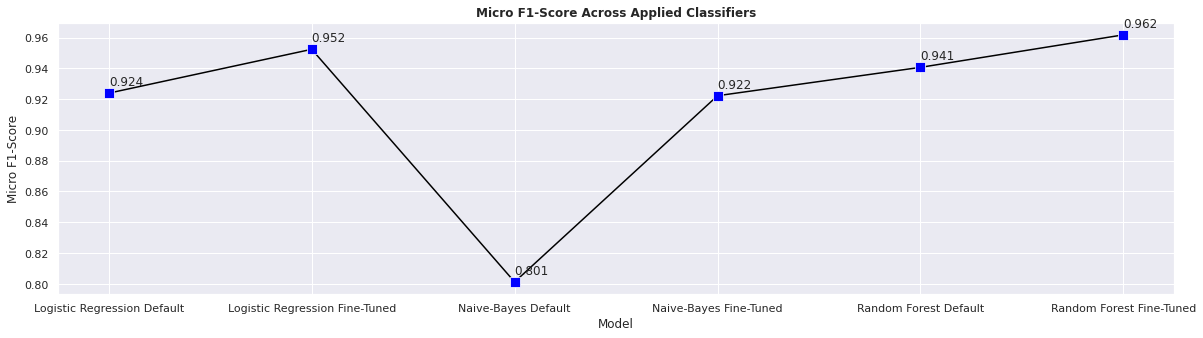

In [85]:
# Plot results for comparison. 

fig, ax = plt.subplots(figsize=(20,5))

ax = sns.lineplot(data = performance_comparison_df, x = "Model", y = "Micro F1-Score", marker = "s", markersize = 10, ax = ax, color = "black", markerfacecolor='blue')
ax.set_title("Micro F1-Score Across Applied Classifiers", weight = 'bold')
for model, score in zip(performance_comparison_df['Model'], performance_comparison_df['Micro F1-Score']):
    ax.annotate(f'{round(score, 3)}', xy=(model, score+0.005))
    

#### 3.3.5.2. Comparing hyperparameter optimization improvements for each model

In [62]:
# Define function to compare confusion matrices of two models. 

def plot_confusionmatrix_comparison(y_test, model1_pred, model2_pred, model1_name, model2_name): 
    
    # Get labels.
    
    cm_labels = np.unique(y_test)
    
    # Get confusion matrix and dataframe.
    
    cm_model1 = confusion_matrix(y_test, model1_pred)
    cm_model1_df = pd.DataFrame(cm_model1, index=cm_labels, columns=cm_labels)
    cm_model2 = confusion_matrix(y_test, model2_pred)
    cm_model2_df = pd.DataFrame(cm_model2, index=cm_labels, columns=cm_labels)

    # Create plots.
    
    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))
    
    ax1.title.set_text(f'Confusion Matrix Heatmap for {model1_name}')
    sns.heatmap(cm_model1_df, annot = True, annot_kws = {"size": 12}, ax = ax1, fmt = 'g', cmap='Blues') 
    
    ax2.title.set_text(f'Confusion Matrix Heatmap for {model2_name}')
    sns.heatmap(cm_model2_df, annot = True, annot_kws = {"size": 12}, ax = ax2, fmt = 'g', cmap='Blues') 
    
    fig.suptitle(f"Hyperparameter optimization Evaluation of {model1_name} and {model2_name}", fontsize = 14, weight = 'bold')

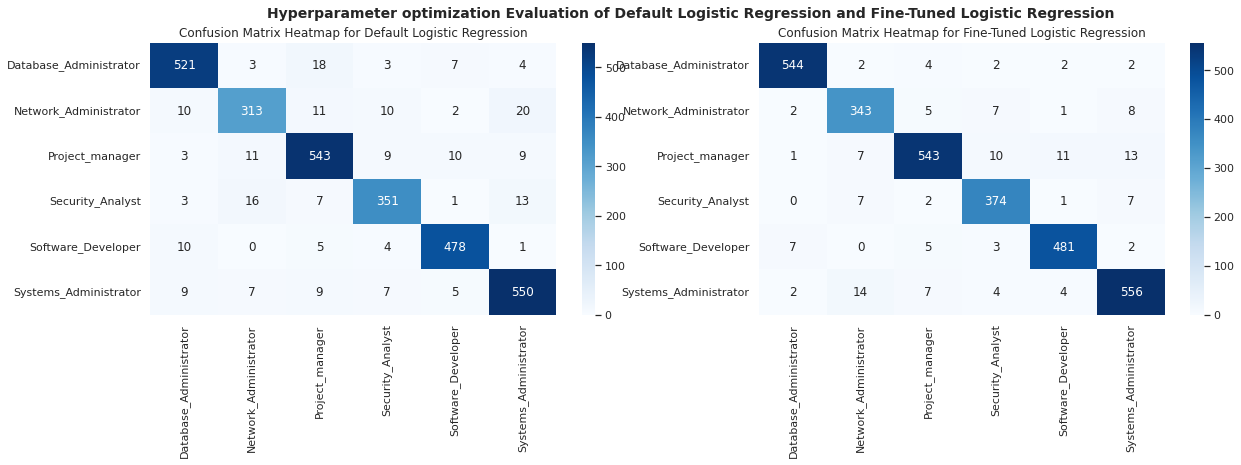

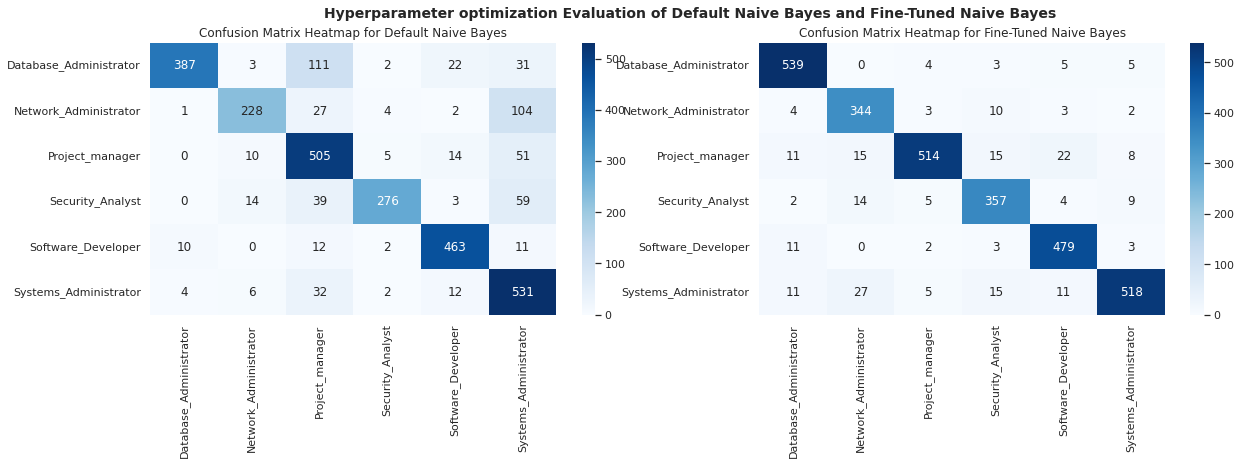

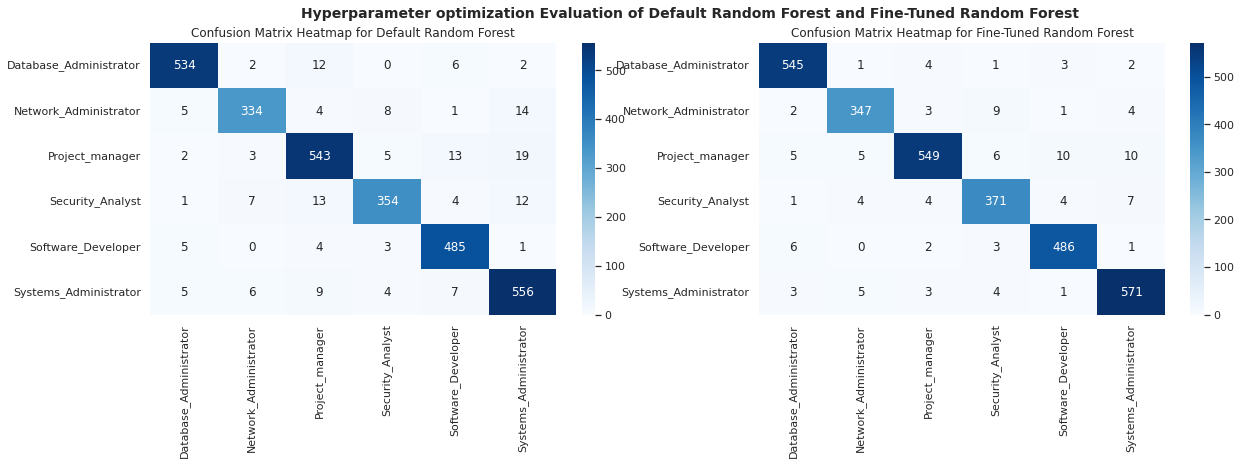

In [64]:
# Plot confusion matrix comparison for the hyperparameter optimization process for all three models. 

plot_confusionmatrix_comparison(y_dev, default_logistic_regression[1], lr_finetune_predictions, 
                                "Default Logistic Regression", "Fine-Tuned Logistic Regression")

plot_confusionmatrix_comparison(y_dev, baseline_predictions_nb, nb_finetune_predictions, 
                                "Default Naive Bayes", "Fine-Tuned Naive Bayes")

plot_confusionmatrix_comparison(y_dev, baseline_predictions_rf, rf_finetune_predictions, 
                                "Default Random Forest", "Fine-Tuned Random Forest")

While all three optimized models show improvements over the baselines, the optimization effect is strongest for the Naive Bayes classifier. 

## 3.4. Performance evaluation and comparison
Lastly, we apply our classifiers to the test data to ultimately evaluate their (artificial out-of-sample) performance. To check for significant improvements over the two baselines, various bootstrapped sampling significance tests are conducted. 

### 3.4.1. Test data predictions and bootstrap sampling significance tests

In [42]:
# Define function for bootstrap sample significance test (from class). 

def bootstrap_sample(system1, system2, gold, samples = 1000, score = f1_score, average = 'micro'):
    """
    compute the proportion of times the performance difference of the 
    two systems on a subsample is significantly different from the 
    performance on the entire sample
    """
    N = len(gold) # Number of instances
    
    # Make sure the two systems have the same number of samples.
    assert len(system1) == N and len(system2) == N, 'samples have different lengths'

    # Compute performance score on entire sample.
    base_score1 = score(gold, system1, average=average)
    base_score2 = score(gold, system2, average=average)

    # Switch systems if system2 is better.
    if base_score2 > base_score1:
        system1, system2 = system2, system1
        base_score1, base_score2 = base_score2, base_score1
    
    # Compute the difference.
    basedelta = base_score1 - base_score2
    assert basedelta > 0, 'Wrong system first, system1 needs to be better!'

    system1 = np.array(system1)
    system2 = np.array(system2)
    gold = np.array(gold)

    p = 0
    deltas = []
    for i in range(samples):
        # Select a subsample, with replacement.
        sample = np.random.choice(N, size=N, replace=True)

        # Collect data corresponding to subsample.
        sample1 = system1[sample]
        sample2 = system2[sample]
        gold_sample = gold[sample]

        # Compute scores on subsample.
        sample_score1 = score(gold_sample, sample1, average=average)
        sample_score2 = score(gold_sample, sample2, average=average)
        sample_delta = sample_score1 - sample_score2

        # Check whether the observed sample difference is at least.
        # Twice as large as the base difference.
        if sample_delta > 2*basedelta:
            p += 1
        deltas.append(sample_delta)
                
    return p/samples, deltas

#### 3.4.1.1. Baselines

In [43]:
# Get baseline predictions and evaluation for test data. 

most_frequent_testpredictions = most_frequent.predict(X_test)
most_frequent_testpredictions_report = classification_report(y_test, most_frequent_testpredictions, output_dict = True)

default_logistic_regression_testpredictions = logistic_regression_default(X_train, y_train, X_test, y_test)[1]
default_logistic_regression_testpredictions_report = classification_report(y_test, 
                                                                           default_logistic_regression_testpredictions, 
                                                                           output_dict = True)

# Conduct bootstrap sampling significance tests.

p_value_default_lr_mostfreq, deltas_default_lr_mostfreq = bootstrap_sample(default_logistic_regression_testpredictions, 
                                                         most_frequent_testpredictions, y_test)

#### 3.4.1.2. Fine-tuned logistic regression

In [44]:
# Get random forest predictions and evaluation for test data. 

finetuned_lr_testpredictions = grid_lr.predict(X_test)
finetuned_lr_testpredictions_report = classification_report(y_test, finetuned_lr_testpredictions, output_dict = True)

# Conduct bootstrap sampling significance tests.

p_value_finetuned_lr_mostfreq, deltas_finetuned_lr_mostfreq = bootstrap_sample(finetuned_lr_testpredictions, 
                                                         most_frequent_testpredictions, y_test)

p_value_finetuned_lr_defaultlr, deltas_finetuned_lr_defaultlr = bootstrap_sample(finetuned_lr_testpredictions, 
                                                         default_logistic_regression_testpredictions, y_test)

#### 3.4.1.3. Fine-Tuned Naive Bayes

In [45]:
# Get predictions and evaluation for test data. 

finetuned_nb_testpredictions = grid_nb.predict(X_test)
finetuned_nb_testpredictions_report = classification_report(y_test, finetuned_nb_testpredictions, output_dict = True)

# Conduct bootstrap sampling significance tests.

p_value_finetuned_nb_mostfreq, deltas_finetuned_nb_mostfreq = bootstrap_sample(finetuned_nb_testpredictions, 
                                                         most_frequent_testpredictions, y_test)

p_value_finetuned_nb_defaultlr, deltas_finetuned_nb_defaultlr = bootstrap_sample(finetuned_nb_testpredictions, 
                                                         default_logistic_regression_testpredictions, y_test)

#### 3.4.1.4. Fine-Tuned Random Forest

In [46]:
# Get predictions and evaluation for test data. 

finetuned_rf_testpredictions = grid_rf.predict(X_test)
finetuned_rf_testpredictions_report = classification_report(y_test, finetuned_rf_testpredictions, output_dict = True)

# Conduct bootstrap sampling significance tests.

p_value_finetuned_rf_mostfreq, deltas_finetuned_rf_mostfreq = bootstrap_sample(finetuned_rf_testpredictions, 
                                                         most_frequent_testpredictions, y_test)

p_value_finetuned_rf_defaultlr, deltas_finetuned_rf_defaultlr = bootstrap_sample(finetuned_rf_testpredictions, 
                                                         default_logistic_regression_testpredictions, y_test)

### 3.4.2. Overall model comparison 

In [47]:
# Put all results into one dataframe. 

performance_comparison = {"Model":["Most Frequent Label Baseline", 
                                   "Default Logistic Regression", 
                                    "Logistic Regression Fine-Tuned",
                                    "Naive-Bayes Fine-Tuned", 
                                    "Random Forest Fine-Tuned"],
                          
                          "Micro F1-Score":[most_frequent_testpredictions_report["accuracy"], 
                              default_logistic_regression_testpredictions_report["accuracy"],
                              classification_report_lr_finetuned["accuracy"],
                              classification_report_nb_finetuned["accuracy"], 
                              classification_report_rf_finetuned["accuracy"]],
                          
                          "P-Value Most-Frequent-Label Baseline": ["-",
                                                                   p_value_default_lr_mostfreq,
                                                                   p_value_finetuned_lr_mostfreq, 
                                                                   p_value_finetuned_nb_mostfreq, 
                                                                   p_value_finetuned_rf_mostfreq, 
                                                                  ], 
                          
                          "P-Value Default Logistic Regresion": ["-",
                                                                 "-",
                                                                 p_value_finetuned_lr_defaultlr, 
                                                                 p_value_finetuned_nb_defaultlr, 
                                                                 p_value_finetuned_rf_defaultlr]}

final_performance_comparison_df = pd.DataFrame(performance_comparison)

#### 3.4.2.1. Comparing overall model performance

In [48]:
# Compare all models for performance and significant improvements for test data. 

final_performance_comparison_df

,Model,Micro F1-Score,P-Value Most-Frequent-Label Baseline,P-Value Default Logistic Regresion
0,Most Frequent Label Baseline,0.196716,-,-
1,Default Logistic Regression,0.914544,0.0,-
2,Logistic Regression Fine-Tuned,0.952397,0.0,0.0
3,Naive-Bayes Fine-Tuned,0.922226,0.0,0.0
4,Random Forest Fine-Tuned,0.961783,0.0,0.0


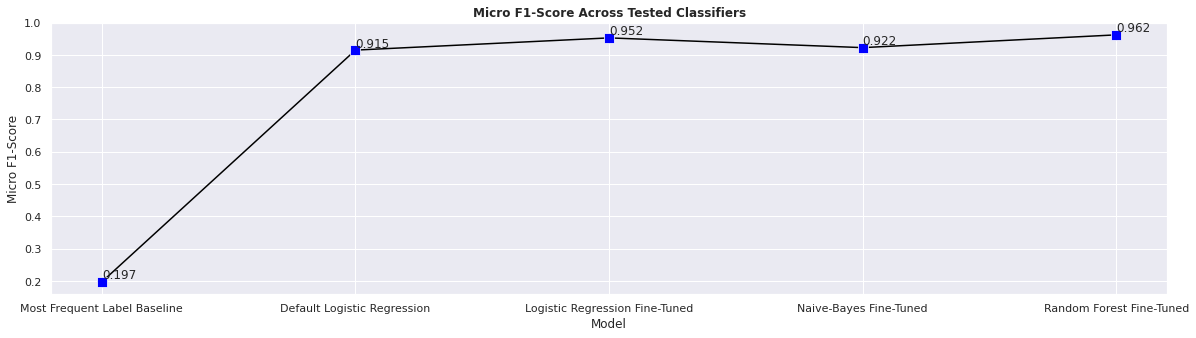

In [90]:
# Plot final model results for test data. 

fig, ax = plt.subplots(figsize=(20,5))

ax = sns.lineplot(data = final_performance_comparison_df, x = "Model", y = "Micro F1-Score", marker = "s", markersize = 10, 
                  ax = ax, color = "black", markerfacecolor='blue')
ax.set_title("Micro F1-Score Across Tested Classifiers", weight='bold')
for model, score in zip(final_performance_comparison_df['Model'], final_performance_comparison_df['Micro F1-Score']):
    ax.annotate(f'{round(score, 3)}', xy=(model, score+0.01))
    

### 3.4.3. Insights into most predictive features

Lastly, we take a look into the most predictive features for our logistic regression model to better understand, which features are most predictive for each label

In [56]:
selector = grid_lr.best_estimator_.named_steps['selector']
best_clf = LogisticRegression(multi_class = 'auto', solver = 'lbfgs', random_state = 999).fit(X_train, y_train)

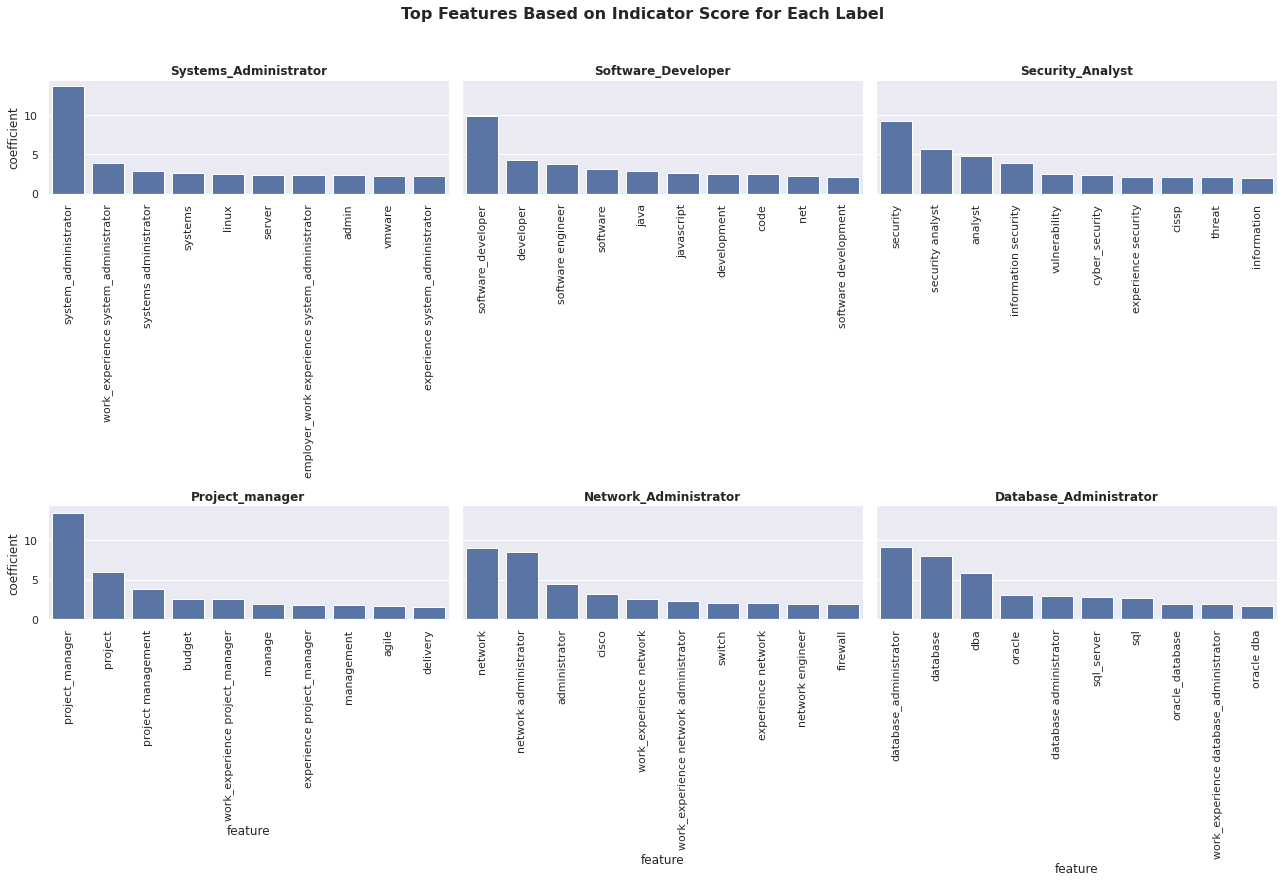

In [95]:
# Get the names of the features.

features = final_tfidf_vectorizer.get_feature_names()
num_feats = len(features)

# Get the indices of the selection.

top_scores = selector.scores_.argsort()[-num_feats:]

# Sort feature names.

best_indicator_terms = [features[i] for i in sorted(top_scores)] 

# Get class with highest weight for each feature.

top_class = [best_clf.classes_[c] for c in best_clf.coef_.argmax(axis = 0)]

# Create a dataframe.

top_indicator_scores = pd.DataFrame(data = {'feature': best_indicator_terms, 
                                          'class': top_class,
                                          'coefficient': best_clf.coef_.max(axis = 0)})

# Sort in descending order.

top_indicator_scores.sort_values('coefficient', ascending = False, inplace = True)

top_indicators = top_indicator_scores.groupby('class').head(10).sort_values(["class", "coefficient"], 
                                                                            axis = 0, ascending = False)

# Create plot.

plot = sns.FacetGrid(top_indicators, col = "class", height = 6, aspect = 1, sharex = False, col_wrap = 3, )
plot1 = plot.map(sns.barplot, "feature", "coefficient")

plot.set_titles(col_template = "{col_name}", size = 12, weight = "bold")

plot.fig.suptitle('Top Features Based on Indicator Score for Each Label', size = 16, y = 1.02, weight = "bold")

for axes in plot.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
    
plt.tight_layout()

# 4. Structured Prediction

<mark> This section is contained in the file ```Structured_prediction_group_8.ipynb```.</mark>